In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
plt.rc('font', family='NanumBarunGothic')
matplotlib.font_manager._rebuild()

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

In [3]:
import os

# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(), # augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_valid = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = './data_30'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'Training'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'Test'), transforms_test)
valid_datasets = datasets.ImageFolder(os.path.join(data_dir, 'Validation'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=4)
valid_dataloader = torch.utils.data.DataLoader(valid_datasets, batch_size=4, shuffle=True, num_workers=4)

print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))
print('valid 데이터셋 크기:', len(valid_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)

학습 데이터셋 크기: 3420
테스트 데이터셋 크기: 483
valid 데이터셋 크기: 450
클래스: ['10013_해태갈배사이다355ML', '10015_롯데핫식스자몽250ML', '10016_동아오츠카데미소다자몽250ML', '10032_롯데마운틴듀355ML', '10033_코카환타포도250ML', '10034_코카콜라제로250ML', '10055_코카콜라355ML', '10056_롯데클라우드클리어제로(캔)350ML', '20004_롯데트로피카나스파클링사과355ML', '20012_롯데)레쓰비190ml', '25328_농심웰치스화이트그레이프맛355ML', '30010_롯데핫식스355ML', '30014_몬스터에너지울트라355ML', '30015_몬스터에너지그린355ML', '30017_롯데밀키스250ML', '30021_몬스터에너지파이프라인펀치355ML', '30033_코카콜라250ML', '30044_맥콜355ML', '40014_농심웰치스포도355ml', '40036_오란씨깔라만시250ML', '40049_코카환타오렌지250ML', '50012_일화맥콜250ML', '60001_롯데칠성사이다로어슈거250ml', '60009_롯데펩시콜라250ML', '60015_롯데트로피카나스파클링망고355ML', '60037_코카환타파인애플250ML', '80010_롯데칠성사이다190ML', '90020_동아데미소다애플250ML', '90040_해태)써니텐오렌지향250ML', '90118_코카콜라)스프라이트250ML']


In [4]:
modelName = 'googlenet'
version = 'v2'
def model_init(modelName, version):
    model = models.googlenet(pretrained=True)
    num_features = model.fc.in_features
    # 전이 학습(transfer learning): 모델의 출력 뉴런 수를 30개로 교체하여 마지막 레이어 다시 학습
    model.fc = nn.Linear(num_features, 30)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    return model, criterion, optimizer

In [5]:
model, criterion, optimizer = model_init(modelName, version)

In [6]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/' + modelName + '_experiment_' + version)

In [12]:
train_losses=[]
train_accu=[]

def train(epoch):
    model.train()

    # 전체 반복(epoch) 수 만큼 반복하며
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.
    
    train_losses.append(epoch_loss)
    train_accu.append(epoch_acc)
    
    writer.add_scalar('Loss/train',
                     epoch_loss,
                     epoch)
    writer.add_scalar('Accu/train',
                     epoch_acc,
                     epoch)

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))
    
    #######
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, "./" + 'checkpoint_' + modelName + '_' + version + '_' + str(epoch) + '.tar')

In [13]:
eval_losses=[]
eval_accu=[]

def valid(epoch):
    model.eval()
    start_time = time.time()
    running_loss=0
    running_corrects=0
    total=0
    
    with torch.no_grad():
        for inputs, labels in valid_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    
    eval_losses.append(epoch_loss)
    eval_accu.append(epoch_acc)
    
    writer.add_scalar('Loss/valid',
                     epoch_loss,
                     epoch)
    writer.add_scalar('Accu/valid',
                     epoch_acc,
                     epoch)
    
    print('[Validation Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

In [15]:
num_epochs = 20

start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    train(epoch)
    valid(epoch)

D:\things\Anaconda\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


#9 Loss: 0.1177 Acc: 96.3158% Time: 845.0567s
[Validation Phase] Loss: 0.0464 Acc: 91.5114% Time: 45.8079s
#10 Loss: 0.1487 Acc: 95.6140% Time: 1710.2335s
[Validation Phase] Loss: 0.0196 Acc: 92.1325% Time: 43.4427s
#11 Loss: 0.1016 Acc: 97.0175% Time: 2573.5103s
[Validation Phase] Loss: 0.0552 Acc: 91.5114% Time: 43.4307s
#12 Loss: 0.0985 Acc: 97.3099% Time: 3408.0151s
[Validation Phase] Loss: 0.0173 Acc: 92.5466% Time: 42.1494s
#13 Loss: 0.1184 Acc: 96.6374% Time: 4232.0824s
[Validation Phase] Loss: 0.0368 Acc: 91.9255% Time: 41.9704s
#14 Loss: 0.0557 Acc: 98.3626% Time: 5089.7550s
[Validation Phase] Loss: 0.3892 Acc: 87.7847% Time: 62.0449s
#15 Loss: 0.1080 Acc: 97.4269% Time: 6025.8053s
[Validation Phase] Loss: 0.0003 Acc: 93.1677% Time: 47.2165s
#16 Loss: 0.0928 Acc: 97.3392% Time: 6896.6309s
[Validation Phase] Loss: 0.0230 Acc: 92.5466% Time: 45.4747s
#17 Loss: 0.0937 Acc: 97.0175% Time: 7749.7866s
[Validation Phase] Loss: 0.0394 Acc: 92.5466% Time: 43.0276s
#18 Loss: 0.0840 Acc:

In [11]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [12]:
import torch
import torchvision
import torchsummary
torchsummary.summary(model, (3, 224, 224),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

training 할 때 validation 과정을 거치지 않아 모델 비교가 불가 -> validation 과정 넣어보자  
이 후 learning curve 그려볼 것 - https://androidkt.com/calculate-total-loss-and-accuracy-at-every-epoch-and-plot-using-matplotlib-in-pytorch/

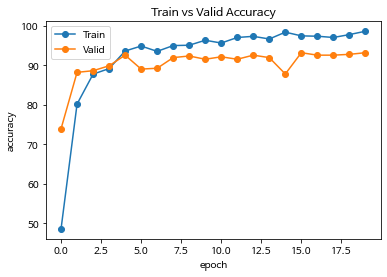

In [16]:
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
 
plt.show()

In [11]:
###### epoch 당 비교

In [17]:
def compare():
    maxAcc = 0
    maxEpoch = -1
    for i in range(0, num_epochs):
        model_init(modelName, version)
        
        checkpoint = torch.load('checkpoint_' + modelName + '_' + version + '_' + str(i) + '.tar')
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        
        model.eval()
        start_time = time.time()

        with torch.no_grad():
            running_loss = 0.
            running_corrects = 0

            for inputs, labels in test_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(test_datasets)
            epoch_acc = running_corrects / len(test_datasets) * 100.
            print('[Test Phase' + str(i) + '] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))
        if epoch_acc > maxAcc: 
            maxAcc = epoch_acc
            maxEpoch = i
    print('max ACC: {:.4f}% at Epoch '.format(maxAcc) + str(maxEpoch))

In [18]:
compare()

[Test Phase0] Loss: 2.3355 Acc: 40.5797% Time: 36.1881s
[Test Phase1] Loss: 2.6797 Acc: 58.3851% Time: 35.8240s
[Test Phase2] Loss: 1.5486 Acc: 67.7019% Time: 36.4892s
[Test Phase3] Loss: 3.1135 Acc: 56.5217% Time: 36.2711s
[Test Phase4] Loss: 2.2451 Acc: 59.6273% Time: 36.1890s
[Test Phase5] Loss: 2.5551 Acc: 57.1429% Time: 36.2811s
[Test Phase6] Loss: 2.8614 Acc: 57.5569% Time: 36.9763s
[Test Phase7] Loss: 2.8350 Acc: 55.9006% Time: 36.3241s
[Test Phase8] Loss: 1.9748 Acc: 63.7681% Time: 36.2381s
[Test Phase9] Loss: 2.7129 Acc: 52.5880% Time: 36.2181s
[Test Phase10] Loss: 2.1304 Acc: 66.4596% Time: 36.1351s
[Test Phase11] Loss: 2.9755 Acc: 55.9006% Time: 36.3061s
[Test Phase12] Loss: 2.3936 Acc: 64.5963% Time: 36.0161s
[Test Phase13] Loss: 2.1901 Acc: 60.4555% Time: 36.8813s
[Test Phase14] Loss: 2.8453 Acc: 55.4865% Time: 36.1911s
[Test Phase15] Loss: 2.1064 Acc: 62.9400% Time: 35.6070s
[Test Phase16] Loss: 3.2210 Acc: 56.7288% Time: 35.7600s
[Test Phase17] Loss: 3.1162 Acc: 43.2712%

In [19]:
def saveTop(epoch):
    model_init(modelName, version)
        
    checkpoint = torch.load('checkpoint_' + modelName + '_' + version + '_' + str(epoch) + '.tar')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    
    torch.save(model, './' + modelName + '_' + version + '.h5')

In [20]:
saveTop(2)